In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
import matplotlib.pyplot as plt

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [143]:
df = pd.read_csv("/kaggle/input/mushroom-dataset/mushroom_cleaned.csv")

In [3]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

def split_dataset(df):
    length = len(df)
    train_split = int(length * 0.8)
    val_split = int(length * 0.9)

    train_dataset = df[:train_split].drop("class", axis=1)
    train_labels = df[:train_split]["class"]
    
    val_dataset = df[train_split: val_split].drop("class", axis=1)
    val_labels = df[train_split: val_split]["class"]

    test_dataset = df[val_split:].drop("class", axis=1)
    test_labels = df[val_split:]["class"]

    return (train_dataset, train_labels), (val_dataset, val_labels), (test_dataset, test_labels)

train_dataset, val_dataset, test_dataset = split_dataset(df)
X_train, y_train = train_dataset
X_val, y_val = val_dataset
X_test, y_test = test_dataset

   cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0          1372          2                2          10     3.807467   
1          1461          2                2          10     3.807467   
2          1371          2                2          10     3.612496   
3          1261          6                2          10     3.787572   
4          1305          6                2          10     3.711971   

   stem-width  stem-color    season  class  
0        1545          11  1.804273      1  
1        1557          11  1.804273      1  
2        1566          11  1.804273      1  
3        1566          11  1.804273      1  
4        1464          11  0.943195      1  


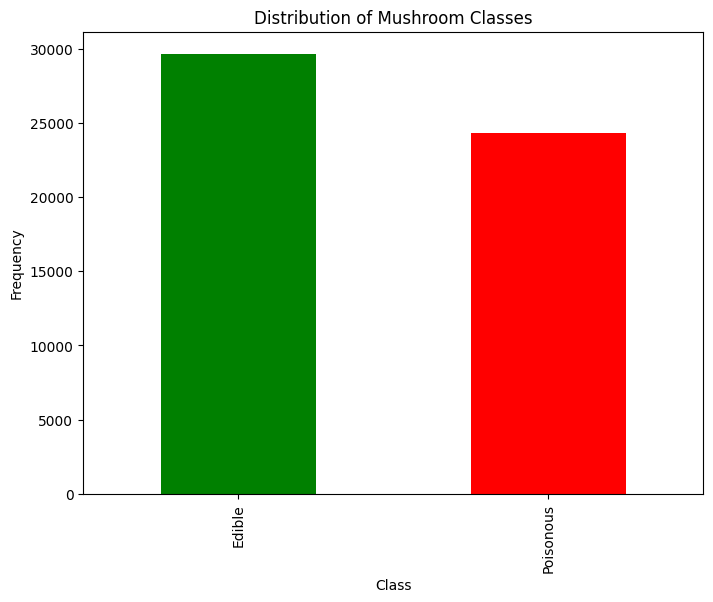

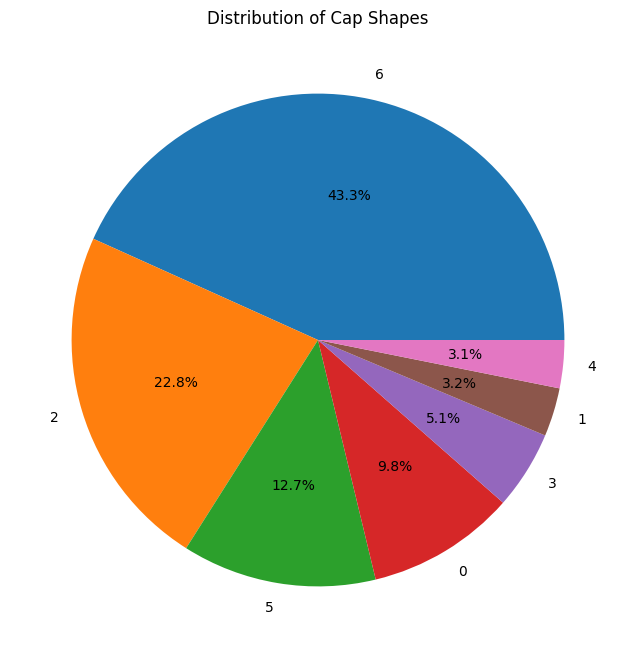

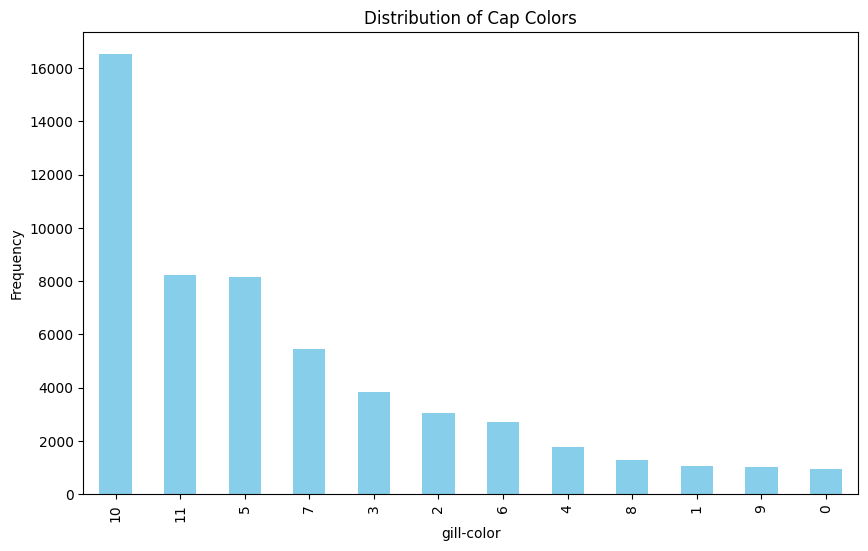

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

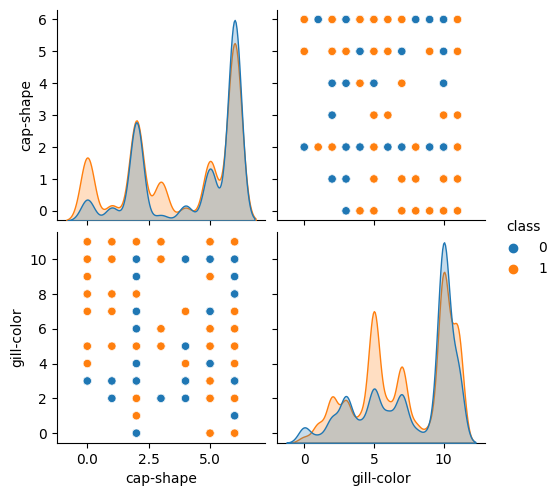

In [4]:

print(df.head())

# Bar Chart of Class Distribution
plt.figure(figsize=(8, 6))
df['class'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Mushroom Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Edible', 'Poisonous'])
plt.show()

# Pie Chart of Cap Shape Distribution
plt.figure(figsize=(8, 8))
df['cap-shape'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Cap Shapes')
plt.ylabel('')
plt.show()

# Bar Chart for Cap Color Distribution
plt.figure(figsize=(10, 6))
df['gill-color'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Cap Colors')
plt.xlabel('gill-color')
plt.ylabel('Frequency')
plt.show()

# Pairplot of selected features
import seaborn as sns

# Selecting a subset of features for visualization
subset_features = df[['class', 'cap-shape', 'gill-color']]
sns.pairplot(subset_features, hue='class')
plt.show()

In [5]:
from torch.utils.data import Dataset

class MushroomDataset(Dataset):
    def __init__(self, X, y):
        self.samples = self.create_dataset(X, y)
        
    def create_dataset(self, X, y):
        samples = []
        for data, label in zip(X.values, y.values):
            data = torch.tensor([float(x) for x in data])
            samples.append((data, label))
        return samples
    
    def __getitem__(self, idx):
        return self.samples[idx]
    
    def __len__(self):
        return len(self.samples)
    
train_dataset = MushroomDataset(X_train, y_train)
val_dataset = MushroomDataset(X_val, y_val)
test_dataset = MushroomDataset(X_test, y_test)

In [6]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [103]:
import torch
from torch.nn import Module, Linear, ReLU, Dropout, Flatten, Sigmoid

class MushroomClassifier(Module):
    def __init__(self, in_features, hidden_units, out_features):
        super().__init__()
        self.linear1 = Linear(in_features, hidden_units)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_units, hidden_units)
        self.linear3 = Linear(hidden_units, out_features)
        self.sigmoid = Sigmoid()
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.sigmoid(out)
        return out


In [110]:
from torch.nn import BCELoss
from torch.optim import Adam
from torch import optim


model = MushroomClassifier(in_features=X_train.shape[1], hidden_units=200, out_features=1).to("cuda")
criterion = BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [119]:


# Training and validation loop
epochs = 5

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for data, labels in train_dataloader:
        data, labels = data.to("cuda"), labels.to("cuda").float()

        optimizer.zero_grad()  # Clear previous gradients
        logits = model(data)  # Forward pass
        loss = criterion(logits.squeeze(), labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_train_loss += loss.item()
    
    # Step the scheduler
    scheduler.step()
    
    # Validate the model
    model.eval()
    running_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for data, labels in val_dataloader:
            data, labels = data.to("cuda"), labels.to("cuda").float()
            logits = model(data)  # Forward pass
            loss = criterion(logits.squeeze(), labels)  # Compute loss
            running_val_loss += loss.item()
            
            # Calculate accuracy
            preds = torch.sigmoid(logits)
            predicted_labels = (preds > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)
    
    val_accuracy = correct_predictions / total_predictions
    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Train Loss: {running_train_loss / len(train_dataloader):.4f}, '
          f'Val Loss: {running_val_loss / len(val_dataloader):.4f}, '
          f'Val Accuracy: {val_accuracy * 100:.2f}%')

# Final evaluation on the test set
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for data, labels in test_dataloader:
        data, labels = data.to("cuda"), labels.to("cuda").float()
        logits = model(data)  # Forward pass
        preds = torch.sigmoid(logits)
        predicted_labels = (preds > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate overall test accuracy
test_accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch [1/5], Train Loss: 42.0716, Val Loss: 63.8526, Val Accuracy: 1155.77%
Epoch [2/5], Train Loss: 43.7702, Val Loss: 63.8697, Val Accuracy: 1156.23%
Epoch [3/5], Train Loss: 26.2630, Val Loss: 0.9391, Val Accuracy: 1156.45%
Epoch [4/5], Train Loss: 0.6112, Val Loss: 0.7374, Val Accuracy: 1155.86%
Epoch [5/5], Train Loss: 0.5873, Val Loss: 0.8319, Val Accuracy: 1156.28%
Test Accuracy: 2032.38%


In [120]:
import torch

# Assuming test_dataloader is already defined
model.eval()
running_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for idx, (data, labels) in enumerate(test_dataloader):
        data, labels = data.to("cuda"), labels.to("cuda")

        preds = model(data)  # Forward pass
        # Apply softmax to the predictions
        preds = torch.softmax(preds, dim=1)
        
        # Get the predicted class by finding the index with the maximum value
        _, predicted_labels = torch.max(preds, 1)
        
        # Calculate the number of correct predictions
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)
        
    accuracy = correct_predictions / total_predictions
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    


Overall Accuracy: 36.38%


In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


std =  StandardScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [177]:
from sklearn.model_selection import train_test_split

X = df.drop("class", axis=1)
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [178]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [179]:
model.score(X_train, y_train)

1.0

In [180]:
model.score(X_val, y_val)

1.0

In [181]:
model.score(X_test, y_test)

0.9902840751364856

In [185]:
new_data = np.array([1372, 2, 2, 10, 3.8, 1545, 11, 1.8]).reshape(1, -1)

# Make predictions
prediction = model.predict(new_data)

print("Predicted class:", prediction)

Predicted class: [1]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [126]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7152109548482606
